# Import library

In [43]:
import pandas as pd
import numpy as np
import math as math
import random
from sklearn.utils import shuffle
import sklearn.preprocessing  as prepro
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
from xgboost import XGBClassifier
# from adjustText import adjust_text


#constants
random_state = 42
plotColor = ['b','g','r','m','c', 'y']
markers = ['+','o','*','^','v','>','<']

#set up
sns.set(style='whitegrid')
%matplotlib inline

# Read Data

In [44]:
data = pd.read_csv('telco_telecom_churn.csv')

In [45]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [46]:
data.shape

(7043, 21)

The dataset has 7043 records with 21 features

In [47]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

## Describtive statistics

### Convert data types

In [48]:
data.TotalCharges

0         29.85
1        1889.5
2        108.15
3       1840.75
4        151.65
         ...   
7038     1990.5
7039     7362.9
7040     346.45
7041      306.6
7042     6844.5
Name: TotalCharges, Length: 7043, dtype: object

In [49]:
# Change totalcharges to float
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')  # Convert to float
# Change SeniorCitizen to object
data['SeniorCitizen'] = data['SeniorCitizen'].astype("object")
# ... existing code ...

In [50]:
data.dtypes

customerID           object
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

Convert TotalCharges to number and SeniorCitizen to Categorical

In [51]:
cat_cols = ["gender","Partner","Dependents","SeniorCitizen","PhoneService","MultipleLines"
                    ,"InternetServiceType","OnlineSecurity","OnlineBackup","DeviceProtection"
                    ,"TechSupport","StreamingTV","StreamingMovies","IsContracted"
                    ,"ContractType","PaperlessBilling","PaymentMethod"]


num_cols = ["Tenure","MonthlyCharges","TotalCharges"]

target_col = 'Churn'

# spliting categorical columns into Nominal and Binary columns

nominal_cols = ['Gender','InternetServiceType','PaymentMethod','ContractType']

binary_cols = ['SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity'
               ,'OnlineBackup' ,'DeviceProtection','TechSupport','StreamingTV', 'StreamingMovies'
               ,'PaperlessBilling','InternetService', 'IsContracted']



In [52]:
data.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


In [53]:
data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


In [54]:
data.select_dtypes(include=['object']).describe().T

,count,unique,top,freq
customerID,7043,7043,7590-VHVEG,1
gender,7043,2,Male,3555
SeniorCitizen,7043,2,0,5901
Partner,7043,2,No,3641
Dependents,7043,2,No,4933
PhoneService,7043,2,Yes,6361
MultipleLines,7043,3,No,3390
InternetService,7043,3,Fiber optic,3096
OnlineSecurity,7043,3,No,3498
OnlineBackup,7043,3,No,3088


# Check for Missing values

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


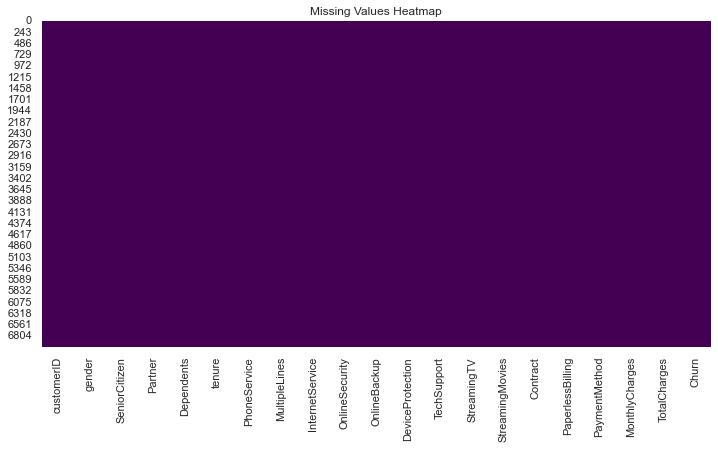

In [55]:
# Visualize missing values
# Check for missing values
missing_values = data.isnull().sum()
print(missing_values)
# Display columns with missing values
missing_values[missing_values > 0]

import seaborn as sns
import matplotlib.pyplot as plt

# Plot missing value heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [14]:
# ... existing code ...
missing_total_charges = data[data['TotalCharges'].isnull()]
missing_total_charges

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [15]:
# ... existing code ...
missing_total_charges_indices = data[data['TotalCharges'].isnull()].index
print(missing_total_charges_indices.tolist())
# ... existing code ...

[488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]


In [16]:
# ... existing code ...
missing_total_charges_instances = data.loc[missing_total_charges_indices]
missing_total_charges_instances# ... existing code ...

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [17]:
data.shape

(7043, 21)

In [18]:
data = data.dropna()

In [19]:
data.shape

(7032, 21)

## Detect duplicate

In [20]:
# ... existing code ...
duplicates = data.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")
# Optionally, print the duplicate rows
duplicate_rows = data[duplicates]
print(duplicate_rows)
# ... existing code ...

Number of duplicate rows: 0
Empty DataFrame
Columns: [customerID, gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn]
Index: []

[0 rows x 21 columns]


The dataframe has no duplicate

# Detect outlier

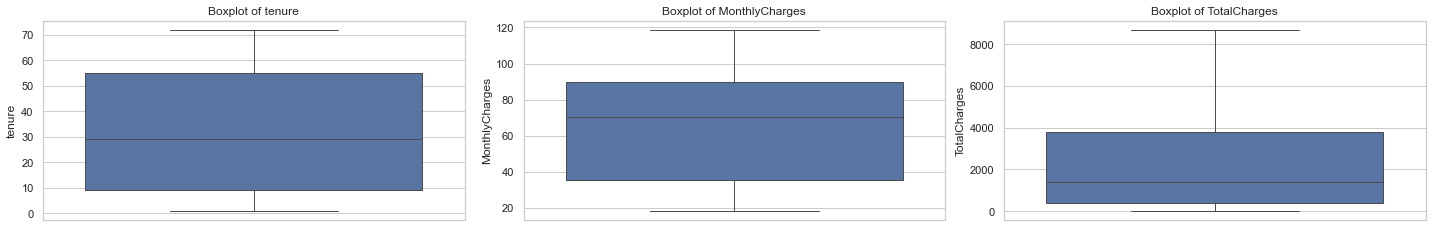

In [21]:
# Plot box plots to visualize outliers in numerical columns
numeric_columns = data.select_dtypes(include=['float64', 'int64', 'int32']).columns.tolist()
plt.figure(figsize=(20,15))

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(5, 3, i)
    sns.boxplot(data[col])
    plt.title(f'Boxplot of {col}')
    
plt.tight_layout()
plt.show()


In [22]:
# Using zscore method
# Finding outlier by Z-Score
from scipy import stats

# Calculate Z-scores for numerical columns
z_scores = np.abs(stats.zscore(data[numeric_columns]))

# Define a threshold to identify outliers (commonly 3 standard deviations)
outliers = np.where(z_scores > 3)

# Print out the indices of rows containing outliers
outlier_indices = np.unique(outliers[0])
outlier_indices


array([], dtype=int64)

There r no outliers in numerical columns

In [23]:
import numpy as np
import pandas as pd
from scipy import stats

# Assuming 'data' is your DataFrame and 'categorical_column' is the column you're analyzing
categorical_column = data.select_dtypes(include=['object','category']).columns.to_list()

# Step 1: Get frequency counts for each category
category_counts = data[categorical_column].value_counts()

# Step 2: Calculate Z-scores for the frequency counts
z_scores = np.abs(stats.zscore(category_counts))

# Step 3: Define a threshold to identify outliers (commonly 3 standard deviations)
outliers = np.where(z_scores > 3)

# Step 4: Get the corresponding categories that are outliers
outlier_categories = category_counts.index[outliers]

# Print out the outlier categories
print(f"Outlier categories in {categorical_column}: {outlier_categories.tolist()}")


Outlier categories in ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']: []


There r no outlier in categorical columns

## Churn distribution

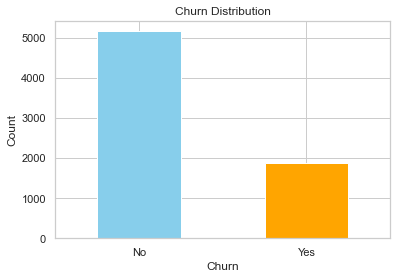

In [24]:
import matplotlib.pyplot as plt

# Churn distribution
churn_counts = data['Churn'].value_counts()

# Plot churn distribution
plt.figure(figsize=(6,4))
churn_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
plt.show()


## Distribution

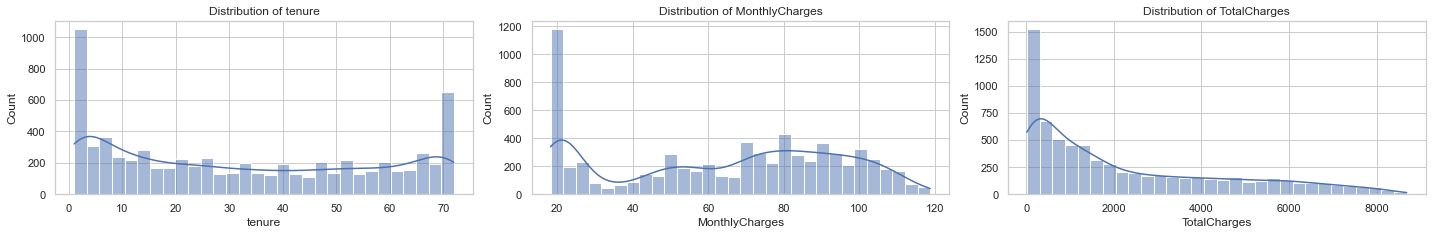

In [25]:
# ... existing code ...
plt.figure(figsize=(20, 15))

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(5, 3, i)
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    
plt.tight_layout()
plt.show()
# ... existing code ...

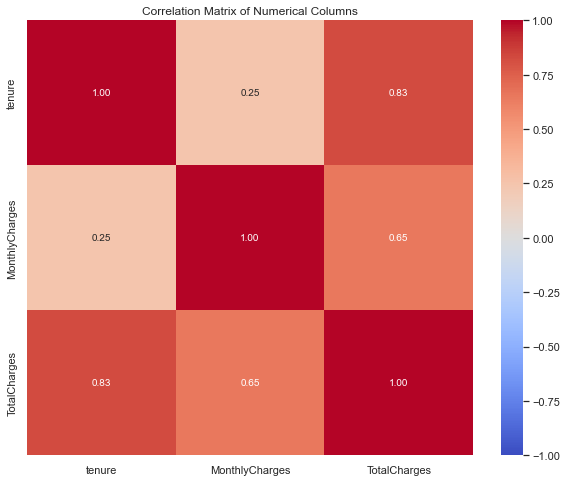

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Identify numerical columns in the dataset
numerical_columns = data.select_dtypes(include=[np.number]).columns

# Calculate the correlation matrix for numerical columns
correlation_matrix = data[numerical_columns].corr()

# Plot a heatmap to visualize the correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Columns')
plt.show()


In [27]:
# Drop the 'TotalCharges' column due to high correlation with other numerical columns
#data = data.drop(columns=['TotalCharges'])

# Display the first few rows of the cleaned data to confirm
data.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


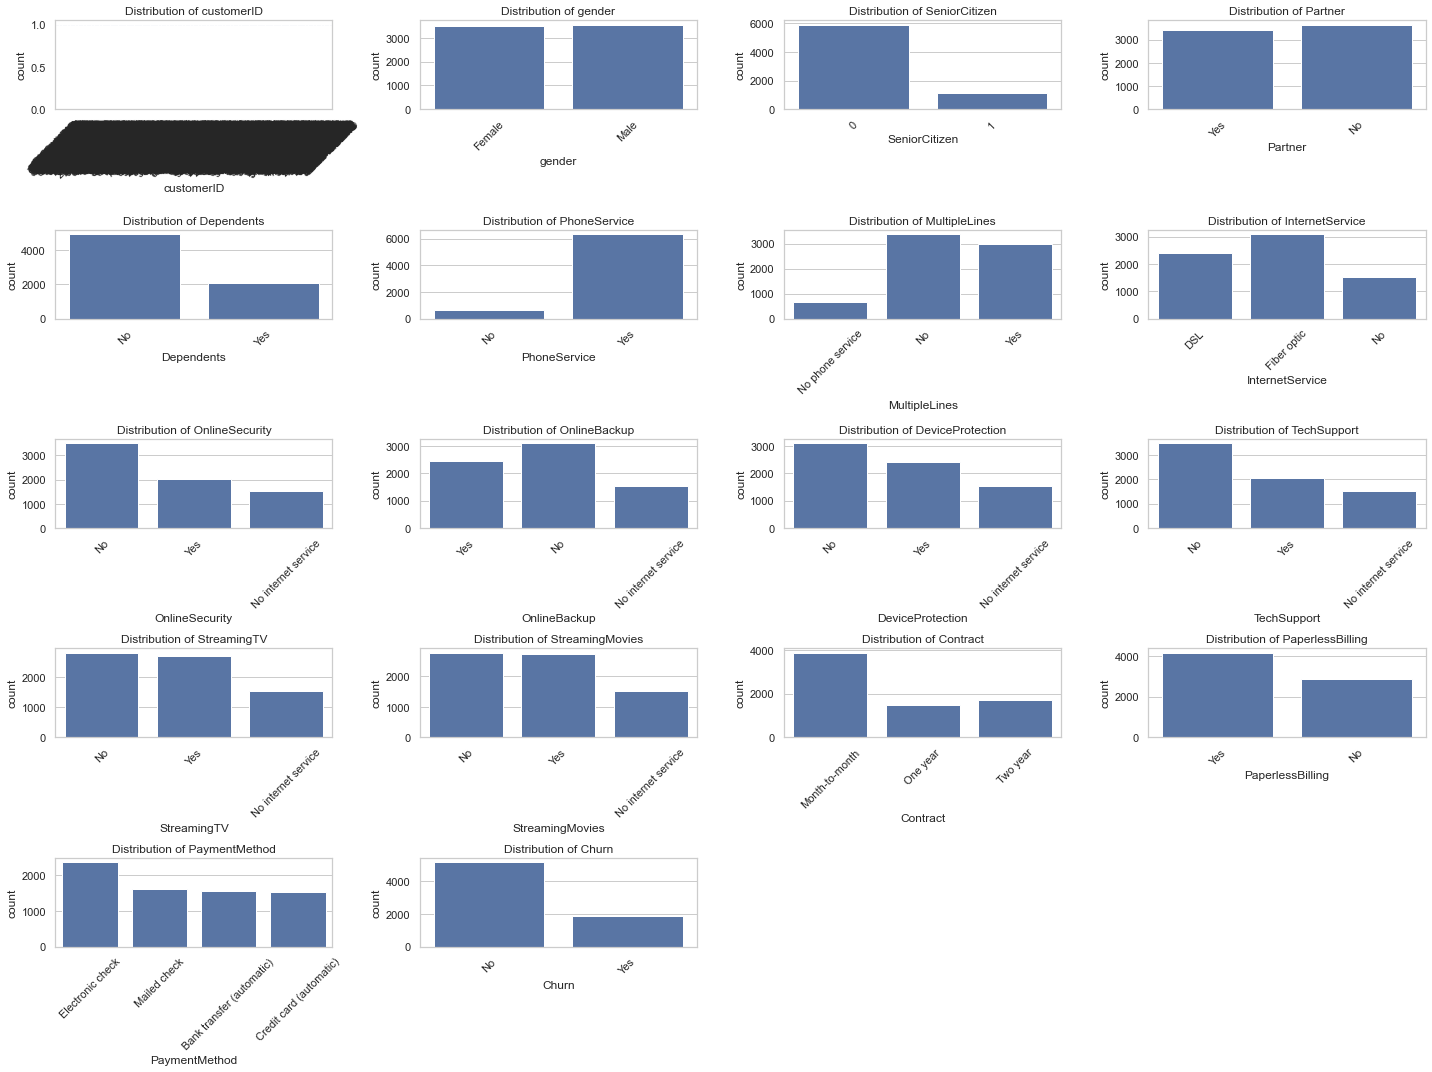

In [28]:
plt.figure(figsize=(20, 15))

for i, col in enumerate(categorical_column, 1):
    plt.subplot(5, 4, i)
    sns.countplot(data=data, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)  # Rotate x labels for better readability
    
plt.tight_layout()
plt.show()

## Perform chi-square

In [29]:
from scipy.stats import chi2_contingency
import pandas as pd

# List of categorical features in the dataset
categorical_features = categorical_column

# Run Chi-Square test for each categorical feature against churn
chi_square_results = {}

for feature in categorical_features:
    # Create a contingency table
    contingency_table = pd.crosstab(data[feature], data['Churn'])
    
    # Perform Chi-Square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Store the results
    chi_square_results[feature] = {'Chi-Square Statistic': chi2, 'P-value': p}

# Convert the results into a DataFrame for better visualization
chi_square_df = pd.DataFrame(chi_square_results).T
chi_square_df

,Chi-Square Statistic,P-value
customerID,7032.000000,4.943933e-01
gender,0.475455,4.904885e-01
SeniorCitizen,158.440816,2.479256e-36
Partner,157.503151,3.973798e-36
Dependents,186.321639,2.019659e-42
PhoneService,0.873733,3.499240e-01
MultipleLines,11.271541,3.567927e-03
InternetService,728.695614,5.831199e-159
OnlineSecurity,846.677389,1.400687e-184
OnlineBackup,599.175185,7.776099e-131


The decision to drop certain columns is guided by the results of the Chi-square test, which measures the association between categorical features and the target variable (likely Churn). Features like customerID, gender, and PhoneService have high p-values (greater than 0.05), suggesting that their association with the target variable is not statistically significant. In essence, these columns do not add meaningful predictive information to the model and could introduce noise or complexity. For example, customerID is a unique identifier and doesn't contain relevant information for predicting churn. Similarly, gender and PhoneService have weak relationships with the target, as indicated by their high p-values, meaning they contribute little to the model's ability to distinguish between different target outcomes. By removing these features, we simplify the model, reduce dimensionality, and focus on features that have a stronger influence on the target, leading to more interpretable and potentially more accurate results.

In [30]:
# List of columns to drop based on high p-values and weak associations
columns_to_drop = ['customerID', 'gender', 'PhoneService']

# Drop the specified columns from the dataset
data_cleaned = data.drop(columns=columns_to_drop)

# Display the resulting dataset
data_cleaned.head()


,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,Yes,No,1,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,0,No,No,34,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,0,No,No,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,0,No,No,45,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,0,No,No,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


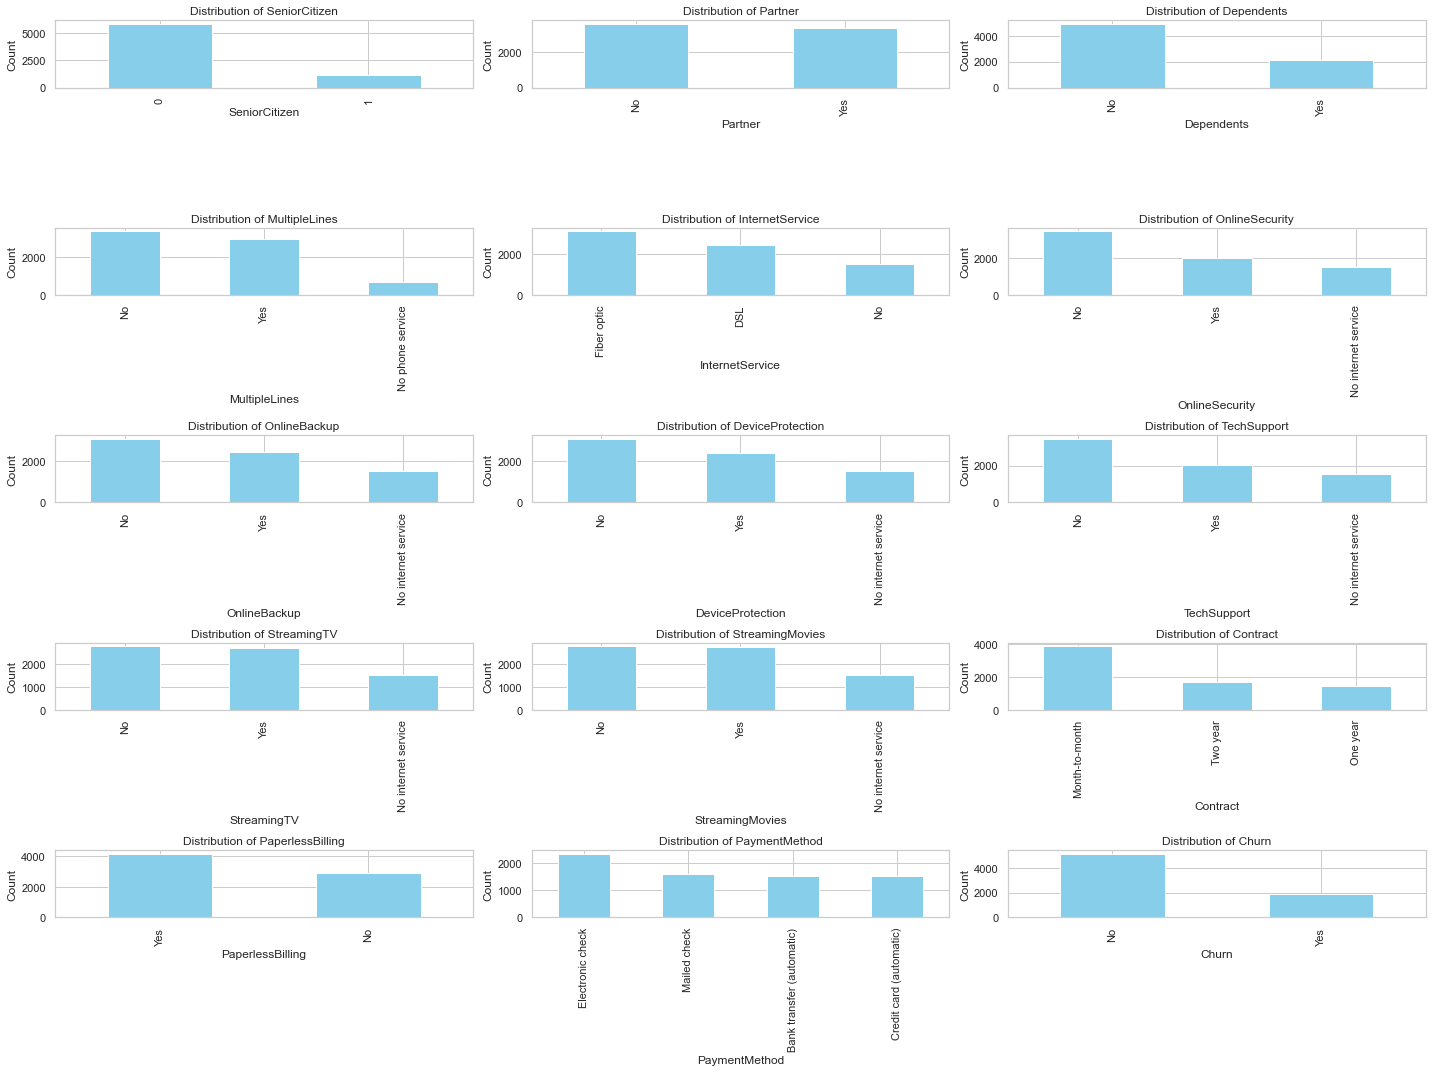

In [31]:
# Distribution of categorical columns
# Plot distribution of categorical columns
categorical_columns = data_cleaned.select_dtypes(include=["category", "object"]).columns.to_list()
plt.figure(figsize=(20,15))

for i, col in enumerate(categorical_columns, 1):
    plt.subplot(5, 3, i)
    data[col].value_counts().plot(kind='bar', color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [32]:
categorical_columns

['SeniorCitizen',
 'Partner',
 'Dependents',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [33]:
columns = ['SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'InternetService',

           'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',

           'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']



# Binary encoding for specific binary columns

binary_columns = ['SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling', 'Churn']

data_cleaned[binary_columns] = data_cleaned[binary_columns].replace({'No': 0, 'Yes': 1, '0':0,'1':1})



# One-Hot Encoding for the remaining columns

onehot_columns = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 

                  'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']

data_cleaned_encoded = pd.get_dummies(data_cleaned, columns=onehot_columns, drop_first=True)


In [34]:
data_cleaned_encoded

,SeniorCitizen,Partner,Dependents,tenure,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,1,29.85,29.85,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,34,0,56.95,1889.50,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0,0,0,2,1,53.85,108.15,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,45,0,42.30,1840.75,0,1,0,...,1,0,0,0,0,1,0,0,0,0
4,0,0,0,2,1,70.70,151.65,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,1,1,24,1,84.80,1990.50,0,0,1,...,1,0,1,0,1,1,0,0,0,1
7039,0,1,1,72,1,103.20,7362.90,0,0,1,...,0,0,1,0,1,1,0,1,0,0
7040,0,1,1,11,1,29.60,346.45,0,1,0,...,0,0,0,0,0,0,0,0,1,0
7041,1,1,0,4,1,74.40,306.60,1,0,1,...,0,0,0,0,0,0,0,0,0,1


In [35]:
data_cleaned_encoded.dtypes

SeniorCitizen                              int64
Partner                                    int64
Dependents                                 int64
tenure                                     int64
PaperlessBilling                           int64
MonthlyCharges                           float64
TotalCharges                             float64
Churn                                      int64
MultipleLines_No phone service             uint8
MultipleLines_Yes                          uint8
InternetService_Fiber optic                uint8
InternetService_No                         uint8
OnlineSecurity_No internet service         uint8
OnlineSecurity_Yes                         uint8
OnlineBackup_No internet service           uint8
OnlineBackup_Yes                           uint8
DeviceProtection_No internet service       uint8
DeviceProtection_Yes                       uint8
TechSupport_No internet service            uint8
TechSupport_Yes                            uint8
StreamingTV_No inter

In [36]:
# ... existing code ...
boolean_columns = data_cleaned_encoded.select_dtypes(include=[bool]).columns
data_cleaned_encoded[boolean_columns] = data_cleaned_encoded[boolean_columns].astype(int)

# Display the first few rows of the numerical DataFrame
data_cleaned_encoded# ... existing code ...

,SeniorCitizen,Partner,Dependents,tenure,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,1,29.85,29.85,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,34,0,56.95,1889.50,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0,0,0,2,1,53.85,108.15,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,45,0,42.30,1840.75,0,1,0,...,1,0,0,0,0,1,0,0,0,0
4,0,0,0,2,1,70.70,151.65,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,1,1,24,1,84.80,1990.50,0,0,1,...,1,0,1,0,1,1,0,0,0,1
7039,0,1,1,72,1,103.20,7362.90,0,0,1,...,0,0,1,0,1,1,0,1,0,0
7040,0,1,1,11,1,29.60,346.45,0,1,0,...,0,0,0,0,0,0,0,0,1,0
7041,1,1,0,4,1,74.40,306.60,1,0,1,...,0,0,0,0,0,0,0,0,0,1


In [37]:
data_cleaned_encoded.dtypes

SeniorCitizen                              int64
Partner                                    int64
Dependents                                 int64
tenure                                     int64
PaperlessBilling                           int64
MonthlyCharges                           float64
TotalCharges                             float64
Churn                                      int64
MultipleLines_No phone service             uint8
MultipleLines_Yes                          uint8
InternetService_Fiber optic                uint8
InternetService_No                         uint8
OnlineSecurity_No internet service         uint8
OnlineSecurity_Yes                         uint8
OnlineBackup_No internet service           uint8
OnlineBackup_Yes                           uint8
DeviceProtection_No internet service       uint8
DeviceProtection_Yes                       uint8
TechSupport_No internet service            uint8
TechSupport_Yes                            uint8
StreamingTV_No inter

In [38]:
# ... existing code ...
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Select only the numerical columns for scaling
numerical_columns = data_cleaned_encoded.select_dtypes(include=[np.number]).columns

# Fit and transform the data
data_scaled = data_cleaned_encoded.copy()
data_scaled[numerical_columns] = scaler.fit_transform(data_cleaned_encoded[numerical_columns])

# Display the first few rows of the scaled DataFrame
print(data_scaled.head())
# ... existing code ...

   SeniorCitizen  Partner  Dependents    tenure  PaperlessBilling  \
0            0.0      1.0         0.0  0.000000               1.0   
1            0.0      0.0         0.0  0.464789               0.0   
2            0.0      0.0         0.0  0.014085               1.0   
3            0.0      0.0         0.0  0.619718               0.0   
4            0.0      0.0         0.0  0.014085               1.0   

   MonthlyCharges  TotalCharges  Churn  MultipleLines_No phone service  \
0        0.115423      0.001275    0.0                             1.0   
1        0.385075      0.215867    0.0                             0.0   
2        0.354229      0.010310    1.0                             0.0   
3        0.239303      0.210241    0.0                             1.0   
4        0.521891      0.015330    1.0                             0.0   

   MultipleLines_Yes  ...  TechSupport_Yes  StreamingTV_No internet service  \
0                0.0  ...              0.0                   

In [39]:
data_scaled.Churn

0       0.0
1       0.0
2       1.0
3       0.0
4       1.0
       ... 
7038    0.0
7039    0.0
7040    0.0
7041    1.0
7042    0.0
Name: Churn, Length: 7032, dtype: float64

In [40]:
data_scaled.to_csv("telco_telecom_churn_preprocessed.csv")

# Data

## Original Data

In [73]:
X = data_scaled.drop(columns="Churn")
y = data_scaled["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print("----------------------------")
print("Original features shape, ", X.shape)
print("Original target shape, ", y.shape)
print("x train shape, ", X_train.shape)
print("y train shape, ", y_train.shape)
print("x test shape, ", X_test.shape)
print("y test shape, ", y_test.shape)
print("----------------------------")

----------------------------
Original features shape,  (7032, 28)
Original target shape,  (7032,)
x train shape,  (5625, 28)
y train shape,  (5625,)
x test shape,  (1407, 28)
y test shape,  (1407,)
----------------------------


## Upsampling data

In [80]:
smote = SMOTE(random_state=42)
X_train_upsampled , y_train_upsampled = smote.fit_resample(X_train,y_train)
print("----------------------------")
print("Original x train shape, ", X_train.shape)
print("Resample x train shape, ", X_train_upsampled.shape)
print("----------------------------")

----------------------------
Original x train shape,  (5625, 28)
Resample x train shape,  (8260, 28)
----------------------------


## Downsampling data

In [81]:
from imblearn.under_sampling import RandomUnderSampler

# Define the undersampler
rus = RandomUnderSampler(random_state=random_state)

# Fit and resample the training data
x_train_downsampled, y_train_downsampled = rus.fit_resample(X_train, y_train)

# Print shapes to compare
print("----------------------------")
print("Original x_train shape: ", X_train.shape)
print("Downsampled x_train shape: ", x_train_downsampled.shape)
print("----------------------------")


----------------------------
Original x_train shape:  (5625, 28)
Downsampled x_train shape:  (2990, 28)
----------------------------


## Synthetic Data (upsampling)

# Build model

## Tuning

In [100]:
def Parameter_tunning(x, y, models, clsModelsNm, parameters, score):
    
    tuned_params = {}
    for i,model in enumerate(models):
        print(clsModelsNm[i])
        grid = GridSearchCV(estimator = model 
                            , cv = 5
                            , param_grid = parameters[clsModelsNm[i]]
                            , scoring = score
                            , n_jobs = 1)
        grid.fit(x,y)
        print(grid.best_score_)
        print(grid.best_params_)
        tuned_params[clsModelsNm[i]] = {'params':grid.best_params_}
    
    return tuned_params

In [121]:
import yaml

with open('../../configs/train_config.yaml', 'r') as file:
    model_params = yaml.safe_load(file)

scoreMatrix = ['accuracy','precision','recall','f1','neg_log_loss']

In [102]:
model_params

{'Random Forest': {'criterion': ['gini', 'entropy'],
  'max_depth': [6, 8],
  'min_samples_leaf': [7, 10],
  'n_estimators': [400, 500]},
 'Decision Tree': {'criterion': ['gini', 'entropy'],
  'max_depth': [6, 8],
  'min_samples_leaf': [7, 10]},
 'Logistic Regression': {'C': [0.1, 1, 10, 100],
  'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
  'max_iter': [100, 200]},
 'XGBoost': {'n_estimators': [400, 500],
  'max_depth': [7, 9],
  'learning_rate': [0.1, 0.2],
  'gamma': [0, 0.1, 0.2, 0.3],
  'reg_alpha': [0, 0.01, 0.1],
  'reg_lambda': [1, 0.1, 0.01]}}

### Original Data

In [103]:
clsLR = LogisticRegression(random_state=random_state)
clsRF = RandomForestClassifier(random_state=random_state)
clsXGB = XGBClassifier(random_state=random_state)
clsDT = DecisionTreeClassifier(random_state=random_state)
clsModelsNm = ["Random Forest", "Decision Tree", "Logistic Regression", "XGBoost"]
clsModels = [clsRF, clsDT, clsLR, clsXGB]
clsParams = model_params
tuned_params = Parameter_tunning(X_train, y_train, clsModels, clsModelsNm, clsParams, 'neg_log_loss')

Random Forest
-0.41218187305016246
{'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 10, 'n_estimators': 500}
Decision Tree
-0.5373757012299025
{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 10}
Logistic Regression


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means

-0.41461791010305565
{'C': 100, 'max_iter': 100, 'solver': 'liblinear'}
XGBoost
-0.42526176570556834
{'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'reg_alpha': 0.1, 'reg_lambda': 1}


In [110]:
import yaml

# Define the model information
model_info = {
    'models': [
        {
            'name': 'Random Forest',
            'negative_log_loss': -0.41218187305016246,
            'hyperparameters': {
                'criterion': 'entropy',
                'max_depth': 8,
                'min_samples_leaf': 10,
                'n_estimators': 500
            }
        },
        {
            'name': 'Decision Tree',
            'negative_log_loss': -0.5373757012299025,
            'hyperparameters': {
                'criterion': 'gini',
                'max_depth': 6,
                'min_samples_leaf': 10
            }
        },
        {
            'name': 'Logistic Regression',
            'negative_log_loss': -0.41461791010305565,
            'hyperparameters': {
                'C': 100,
                'max_iter': 100,
                'solver': 'liblinear'
            }
        },
        {
            'name': 'XGBoost',
            'negative_log_loss': -0.42526176570556834,
            'hyperparameters': {
                'gamma': 0.3,
                'learning_rate': 0.1,
                'max_depth': 7,
                'n_estimators': 500,
                'reg_alpha': 0.1,
                'reg_lambda': 1
            }
        }
    ]
}

# Write to a YAML file
output_path = '../../model_artifact/training/telco/original.yaml'
with open(output_path, 'w') as file:
    yaml.dump(model_info, file, default_flow_style=False)

print(f"Model information has been written to {output_path}")


Model information has been written to ../../model_artifact/training/telco/original.yaml


### Upsampling

In [104]:
clsLR = LogisticRegression(random_state=random_state)
clsRF = RandomForestClassifier(random_state=random_state)
clsXGB = XGBClassifier(random_state=random_state)
clsDT = DecisionTreeClassifier(random_state=random_state)
clsModelsNm = ["Random Forest", "Decision Tree", "Logistic Regression", "XGBoost"]
clsModels = [clsRF, clsDT, clsLR, clsXGB]
clsParams = model_params
tuned_params = Parameter_tunning(X_train_upsampled, y_train_upsampled, clsModels, clsModelsNm, clsParams, 'neg_log_loss')

Random Forest
-0.4275286647482763
{'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 7, 'n_estimators': 400}
Decision Tree
-0.5536273459444652
{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 7}
Logistic Regression


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means

-0.47183264945133907
{'C': 100, 'max_iter': 100, 'solver': 'lbfgs'}
XGBoost
-0.35727827876005647
{'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 400, 'reg_alpha': 0.1, 'reg_lambda': 1}


In [109]:
import yaml

# Define the model information
model_info = {
    'models': [
        {
            'name': 'Random Forest',
            'negative_log_loss': -0.4275286647482763,
            'hyperparameters': {
                'criterion': 'entropy',
                'max_depth': 8,
                'min_samples_leaf': 7,
                'n_estimators': 400
            }
        },
        {
            'name': 'Decision Tree',
            'negative_log_loss': -0.5536273459444652,
            'hyperparameters': {
                'criterion': 'gini',
                'max_depth': 6,
                'min_samples_leaf': 7
            }
        },
        {
            'name': 'Logistic Regression',
            'negative_log_loss': -0.47183264945133907,
            'hyperparameters': {
                'C': 100,
                'max_iter': 100,
                'solver': 'lbfgs'
            }
        },
        {
            'name': 'XGBoost',
            'negative_log_loss': -0.35727827876005647,
            'hyperparameters': {
                'gamma': 0.3,
                'learning_rate': 0.1,
                'max_depth': 9,
                'n_estimators': 400,
                'reg_alpha': 0.1,
                'reg_lambda': 1
            }
        }
    ]
}

# Write to a YAML file
output_path = '../../model_artifact/training/telco/oversampling.yaml'
with open(output_path, 'w') as file:
    yaml.dump(model_info, file, default_flow_style=False)

print(f"Model information has been written to {output_path}")


Model information has been written to ../../model_artifact/training/telco/oversampling.yaml


### Downsampling

In [105]:
clsLR = LogisticRegression(random_state=random_state)
clsRF = RandomForestClassifier(random_state=random_state)
clsXGB = XGBClassifier(random_state=random_state)
clsDT = DecisionTreeClassifier(random_state=random_state)
clsModelsNm = ["Random Forest", "Decision Tree", "Logistic Regression", "XGBoost"]
clsModels = [clsRF, clsDT, clsLR, clsXGB]
clsParams = model_params
tuned_params = Parameter_tunning(x_train_downsampled, y_train_downsampled, clsModels, clsModelsNm, clsParams, 'neg_log_loss')

Random Forest
-0.47633009145220057
{'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 7, 'n_estimators': 400}
Decision Tree
-0.7395808340456078
{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 10}
Logistic Regression


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means

-0.47627586579100234
{'C': 10, 'max_iter': 100, 'solver': 'lbfgs'}
XGBoost
-0.4929849447702798
{'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 400, 'reg_alpha': 0.01, 'reg_lambda': 1}


In [108]:
import yaml

# Define the model information
model_info = {
    'models': [
        {
            'name': 'Random Forest',
            'negative_log_loss': -0.47633009145220057,
            'hyperparameters': {
                'criterion': 'entropy',
                'max_depth': 8,
                'min_samples_leaf': 7,
                'n_estimators': 400
            }
        },
        {
            'name': 'Decision Tree',
            'negative_log_loss': -0.7395808340456078,
            'hyperparameters': {
                'criterion': 'gini',
                'max_depth': 6,
                'min_samples_leaf': 10
            }
        },
        {
            'name': 'Logistic Regression',
            'negative_log_loss': -0.47627586579100234,
            'hyperparameters': {
                'C': 10,
                'max_iter': 100,
                'solver': 'lbfgs'
            }
        },
        {
            'name': 'XGBoost',
            'negative_log_loss': -0.4929849447702798,
            'hyperparameters': {
                'gamma': 0.3,
                'learning_rate': 0.1,
                'max_depth': 7,
                'n_estimators': 400,
                'reg_alpha': 0.01,
                'reg_lambda': 1
            }
        }
    ]
}

# Write to a YAML file
output_path = '../../model_artifact/training/telco/oversampling.yaml'
with open(output_path, 'w') as file:
    yaml.dump(model_info, file, default_flow_style=False)

print(f"Model information has been written to {output_path}")

Model information has been written to ../../model_artifact/training/telco/oversampling.yaml


In [107]:
import yaml

# Define the model information
model_info = {
    'models': [
        {
            'name': 'Random Forest',
            'negative_log_loss': -0.47633009145220057,
            'hyperparameters': {
                'criterion': 'entropy',
                'max_depth': 8,
                'min_samples_leaf': 7,
                'n_estimators': 400
            }
        },
        {
            'name': 'Decision Tree',
            'negative_log_loss': -0.7395808340456078,
            'hyperparameters': {
                'criterion': 'gini',
                'max_depth': 6,
                'min_samples_leaf': 10
            }
        },
        {
            'name': 'Logistic Regression',
            'negative_log_loss': -0.47627586579100234,
            'hyperparameters': {
                'C': 10,
                'max_iter': 100,
                'solver': 'lbfgs'
            }
        },
        {
            'name': 'XGBoost',
            'negative_log_loss': -0.4929849447702798,
            'hyperparameters': {
                'gamma': 0.3,
                'learning_rate': 0.1,
                'max_depth': 7,
                'n_estimators': 400,
                'reg_alpha': 0.01,
                'reg_lambda': 1
            }
        }
    ]
}

# Write to a YAML file
with open('../../model_artifact/training/telco/undersampling.yaml', 'w') as file:
    yaml.dump(model_info, file, default_flow_style=False)

print("Model information has been written to undersampling.yaml")

Model information has been written to model_info.yaml


## Visualizing

In [127]:
# Graph of precision & recall against threshold
def plot_precision_recall_vs_thresold(precisions, recalls, thresholds):
    plt.plot(thresholds,precisions[:-1],label="Precision")
    plt.plot(thresholds,recalls[:-1],label="Recall")
    plt.plot(thresholds,2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1]+recalls[:-1]) ,label="F1")
    plt.title("Precision, recall & F1 vs thresold")
    plt.xlabel("Thresold")
    plt.legend(loc='lower right')
    plt.show()

In [128]:
def Cross_validation_score(clsModels, clsModelsNm, clsSample, scoreMatrix):
    """ Cross validation using cross_val_score method """
    for i,model in enumerate(clsModels):
        print("===============================================")
        print(clsModelsNm[i])

        for j, sample in enumerate(clsSample):
            print("************************************************")
            print(sample[2])
            
            for score in scoreMatrix:
                scores = cross_val_score(model, sample[0], sample[1], cv=5 , scoring = score)
                print(score, " score:", scores.mean())
                
            y_scores = cross_val_predict(model, sample[0], sample[1], cv=5, method="predict_proba") 
            
            
            precisions, recalls, thresholds = metrics.precision_recall_curve(sample[1], y_scores[:][:,1]) 
            plot_precision_recall_vs_thresold(precisions, recalls, thresholds)
            score_matrix = pd.DataFrame({'Precisions': precisions[:-1]
                                ,'Recalls': recalls[:-1]
                                ,'F1': 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1]+recalls[:-1])
                                ,'Threshold': thresholds
                               })
            #print("When percision and recall are same \n" , score_matrix[ score_matrix['Precisions'] == score_matrix['Recalls']] )
            print("When F1 score is max \n" , score_matrix[ score_matrix['F1'] == max(score_matrix['F1'])])

### Original data

Random Forest Parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 10, 'n_estimators': 500}
Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 10}
Logistic Regression Parameters: {'C': 100, 'max_iter': 100, 'solver': 'liblinear'}
XGBoost Parameters: {'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'reg_alpha': 0.1, 'reg_lambda': 1}
Random Forest
************************************************
Original data
accuracy  score: 0.8064
precision  score: 0.6741041591441823
recall  score: 0.5190635451505016
f1  score: 0.58389301605698
neg_log_loss  score: -0.4125088035376089


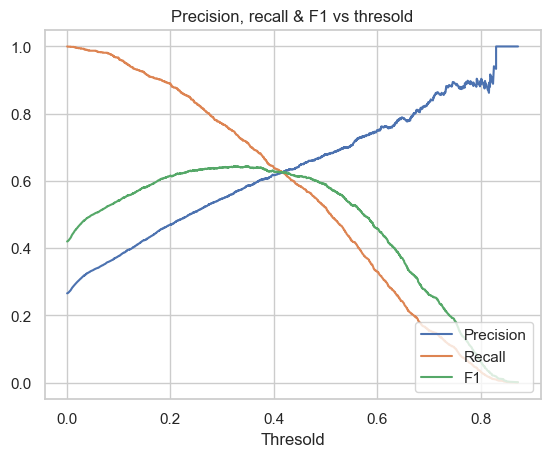

When F1 score is max 
       Precisions   Recalls        F1  Threshold
3638    0.565923  0.746488  0.643784   0.323857
Decision Tree
************************************************
Original data
accuracy  score: 0.7893333333333333
precision  score: 0.6158729086750381
recall  score: 0.5478260869565219
f1  score: 0.5787802705995985
neg_log_loss  score: -0.5372788961281606


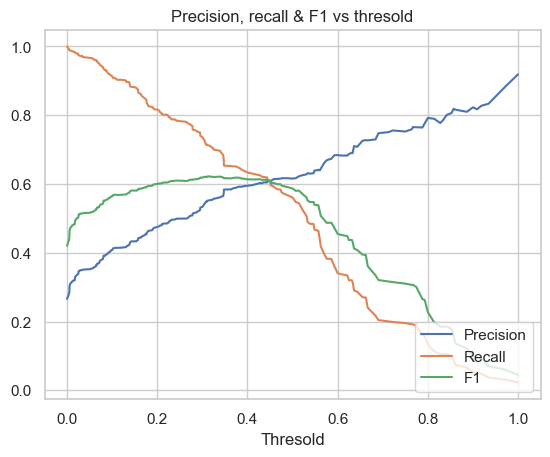

When F1 score is max 
      Precisions   Recalls       F1  Threshold
117     0.55244  0.711706  0.62204   0.315217
Logistic Regression
************************************************
Original data
accuracy  score: 0.8071111111111111
precision  score: 0.6613926451306946
recall  score: 0.5618729096989966
f1  score: 0.6075569630107006
neg_log_loss  score: -0.41461791010305565


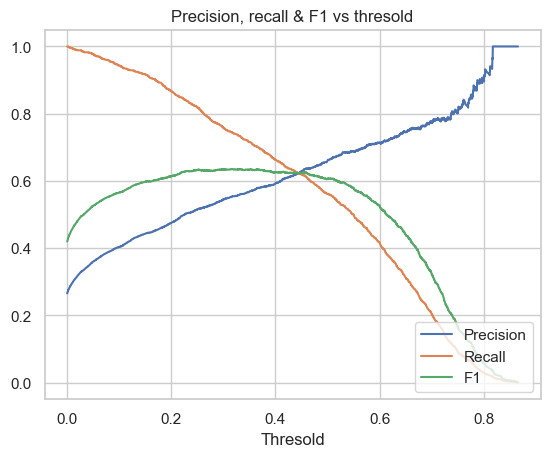

When F1 score is max 
       Precisions  Recalls        F1  Threshold
3662    0.561188  0.73311  0.635731   0.332674
XGBoost
************************************************
Original data
accuracy  score: 0.8005333333333333
precision  score: 0.6513808591216504
recall  score: 0.5357859531772575
f1  score: 0.5877575350651073
neg_log_loss  score: -0.42526176570556834


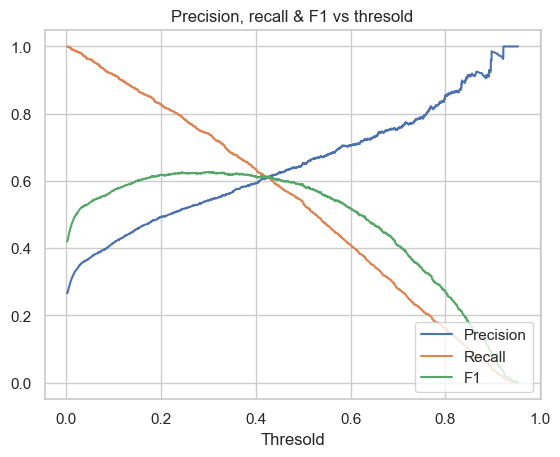

When F1 score is max 
       Precisions   Recalls        F1  Threshold
3524    0.541992  0.742475  0.626588     0.2982


In [137]:
import yaml

# Load the YAML file
with open('../../model_artifact/training/telco/original.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Get the list of models
models = config["models"]

# Extract hyperparameters for each model
og_random_forest_params = next(model['hyperparameters'] for model in models if model['name'] == 'Random Forest')
og_decision_tree_params = next(model['hyperparameters'] for model in models if model['name'] == 'Decision Tree')
og_logistic_regression_params = next(model['hyperparameters'] for model in models if model['name'] == 'Logistic Regression')
og_xgboost_params = next(model['hyperparameters'] for model in models if model['name'] == 'XGBoost')

# Print the hyperparameters for each model
print("Random Forest Parameters:", og_random_forest_params)
print("Decision Tree Parameters:", og_decision_tree_params)
print("Logistic Regression Parameters:", og_logistic_regression_params)
print("XGBoost Parameters:", og_xgboost_params)

# Build model and evaluate
og_clsDT = DecisionTreeClassifier(**og_decision_tree_params)
og_clsLR = LogisticRegression(**og_logistic_regression_params)
og_clsXGB = XGBClassifier(**og_xgboost_params)
og_clsRF = RandomForestClassifier(**og_random_forest_params)

og_clsModels = [og_clsRF, og_clsDT, og_clsLR, og_clsXGB]
Cross_validation_score(og_clsModels, clsModelsNm, [(X_train, y_train,'Original data')], scoreMatrix)

In [130]:
clsModelsNm

['Random Forest', 'Decision Tree', 'Logistic Regression', 'XGBoost']

### Upsampling data

Random Forest Parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 7, 'n_estimators': 400}
Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 7}
Logistic Regression Parameters: {'C': 100, 'max_iter': 100, 'solver': 'lbfgs'}
XGBoost Parameters: {'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 400, 'reg_alpha': 0.1, 'reg_lambda': 1}
Random Forest
************************************************
Upsamping data
accuracy  score: 0.8092009685230025
precision  score: 0.7867488888771323
recall  score: 0.8523002421307506
f1  score: 0.8162962959108508
neg_log_loss  score: -0.4268478281949708


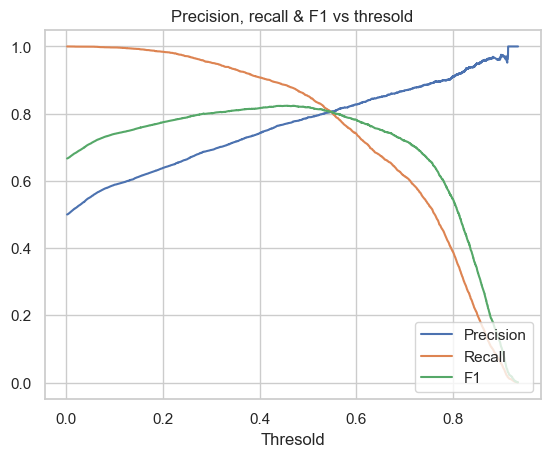

When F1 score is max 
       Precisions   Recalls        F1  Threshold
3506    0.770561  0.884746  0.823715   0.455383
Decision Tree
************************************************
Upsamping data
accuracy  score: 0.7808716707021791
precision  score: 0.7596856801103679
recall  score: 0.8225181598062953
f1  score: 0.7889794335058572
neg_log_loss  score: -0.5535922932034117


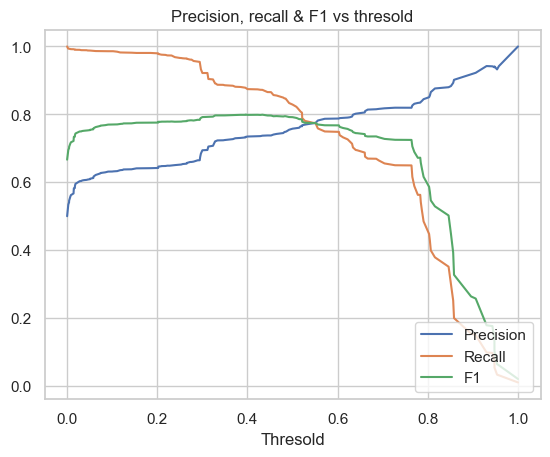

When F1 score is max 
     Precisions   Recalls        F1  Threshold
83    0.733563  0.877966  0.799295   0.395833
Logistic Regression
************************************************
Upsamping data
accuracy  score: 0.7728813559322034
precision  score: 0.7536802685577152
recall  score: 0.8111380145278451
f1  score: 0.7811505494382134
neg_log_loss  score: -0.47183264945133907


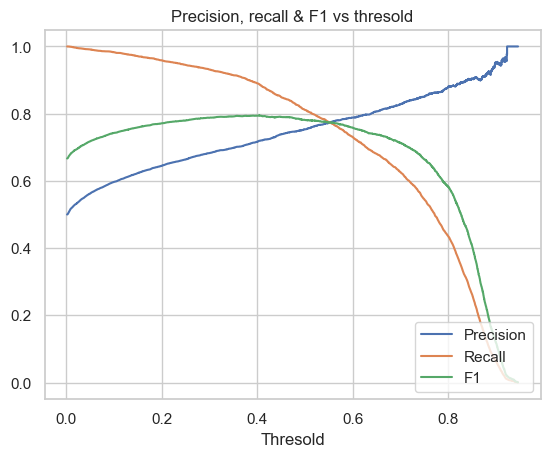

When F1 score is max 
       Precisions   Recalls        F1  Threshold
3161    0.719357  0.888136  0.794886   0.403967
XGBoost
************************************************
Upsamping data
accuracy  score: 0.8426150121065377
precision  score: 0.8363489891115987
recall  score: 0.8508474576271187
f1  score: 0.8363277498951815
neg_log_loss  score: -0.35727827876005647


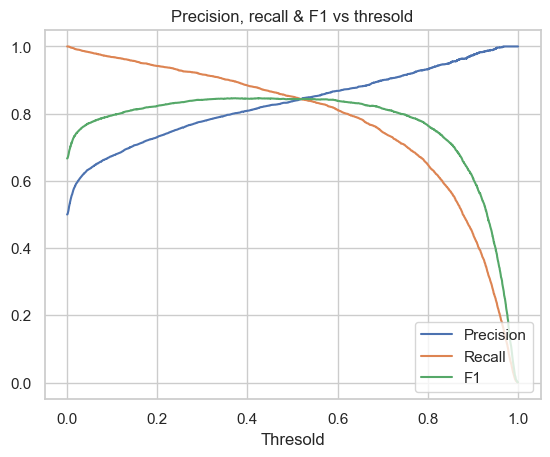

When F1 score is max 
       Precisions   Recalls        F1  Threshold
3822    0.818985  0.875303  0.846208   0.427983


In [138]:
import yaml

# Load the YAML file
with open('../../model_artifact/training/telco/oversampling.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Get the list of models
models = config["models"]

# Extract hyperparameters for each model
os_random_forest_params = next(model['hyperparameters'] for model in models if model['name'] == 'Random Forest')
os_decision_tree_params = next(model['hyperparameters'] for model in models if model['name'] == 'Decision Tree')
os_logistic_regression_params = next(model['hyperparameters'] for model in models if model['name'] == 'Logistic Regression')
os_xgboost_params = next(model['hyperparameters'] for model in models if model['name'] == 'XGBoost')

# Print the hyperparameters for each model
print("Random Forest Parameters:", os_random_forest_params)
print("Decision Tree Parameters:", os_decision_tree_params)
print("Logistic Regression Parameters:", os_logistic_regression_params)
print("XGBoost Parameters:", os_xgboost_params)

# Build model and evaluate
os_clsDT = DecisionTreeClassifier(**os_decision_tree_params)
os_clsLR = LogisticRegression(**os_logistic_regression_params)
os_clsXGB = XGBClassifier(**os_xgboost_params)
os_clsRF = RandomForestClassifier(**os_random_forest_params)

os_clsModels = [os_clsRF, os_clsDT, os_clsLR, os_clsXGB]
Cross_validation_score(os_clsModels, clsModelsNm, [(X_train_upsampled, y_train_upsampled,'Upsamping data')], scoreMatrix)

### Undersampling

Random Forest Parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 7, 'n_estimators': 400}
Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 10}
Logistic Regression Parameters: {'C': 10, 'max_iter': 100, 'solver': 'lbfgs'}
XGBoost Parameters: {'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 400, 'reg_alpha': 0.01, 'reg_lambda': 1}
Random Forest
************************************************
Undersampling data


accuracy  score: 0.7702341137123747
precision  score: 0.7530513024090427
recall  score: 0.7959866220735787
f1  score: 0.774451138326767
neg_log_loss  score: -0.47558452445751864


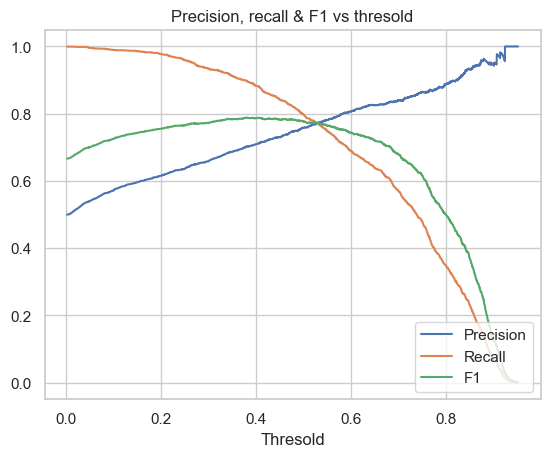

When F1 score is max 
       Precisions   Recalls        F1  Threshold
1076    0.702561  0.898997  0.788732   0.380141
Decision Tree
************************************************
Undersampling data
accuracy  score: 0.7565217391304347
precision  score: 0.7392179811376354
recall  score: 0.7906354515050168
f1  score: 0.7644531105433158
neg_log_loss  score: -0.7401940558117788


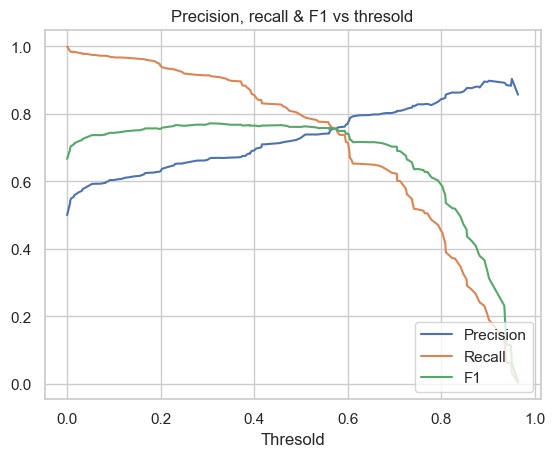

When F1 score is max 
     Precisions   Recalls        F1  Threshold
48     0.66945  0.911706  0.772019   0.307692
Logistic Regression
************************************************
Undersampling data
accuracy  score: 0.7622073578595319
precision  score: 0.7433116124753614
recall  score: 0.8006688963210703
f1  score: 0.7706825855213253
neg_log_loss  score: -0.47627586579100234


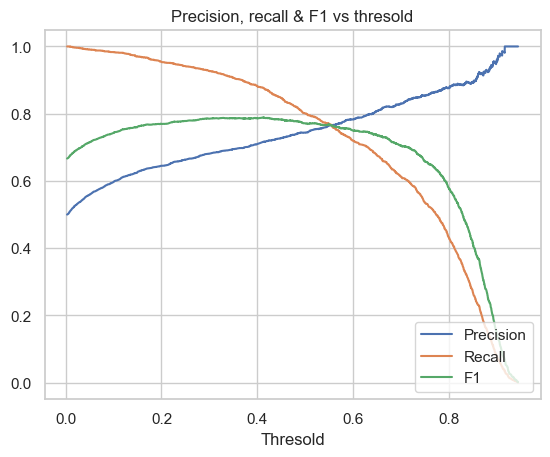

When F1 score is max 
       Precisions   Recalls        F1  Threshold
1158    0.716157  0.877592  0.788699   0.411026
XGBoost
************************************************
Undersampling data
accuracy  score: 0.7548494983277592
precision  score: 0.7399537852919668
recall  score: 0.7859531772575251
f1  score: 0.7621924275953157
neg_log_loss  score: -0.4929849447702798


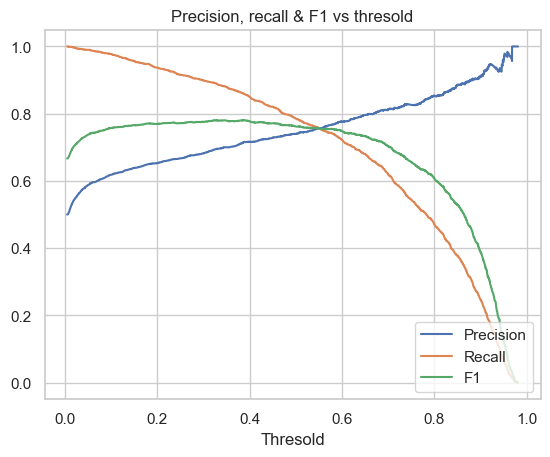

When F1 score is max 
       Precisions  Recalls        F1  Threshold
1186       0.715  0.86087  0.781184   0.386117


In [139]:
import yaml

# Load the YAML file
with open('../../model_artifact/training/telco/undersampling.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Get the list of models
models = config["models"]

# Extract hyperparameters for each model
us_random_forest_params = next(model['hyperparameters'] for model in models if model['name'] == 'Random Forest')
us_decision_tree_params = next(model['hyperparameters'] for model in models if model['name'] == 'Decision Tree')
us_logistic_regression_params = next(model['hyperparameters'] for model in models if model['name'] == 'Logistic Regression')
us_xgboost_params = next(model['hyperparameters'] for model in models if model['name'] == 'XGBoost')

# Print the hyperparameters for each model
print("Random Forest Parameters:", us_random_forest_params)
print("Decision Tree Parameters:", us_decision_tree_params)
print("Logistic Regression Parameters:", us_logistic_regression_params)
print("XGBoost Parameters:", us_xgboost_params)

# Build model and evaluate
us_clsDT = DecisionTreeClassifier(**us_decision_tree_params)
us_clsLR = LogisticRegression(**us_logistic_regression_params)
us_clsXGB = XGBClassifier(**us_xgboost_params)
us_clsRF = RandomForestClassifier(**us_random_forest_params)

us_clsModels = [us_clsRF, us_clsDT, us_clsLR, us_clsXGB]
Cross_validation_score(us_clsModels, clsModelsNm, [(x_train_downsampled, y_train_downsampled,'Undersampling data')], scoreMatrix)

## Model Evalualtion

In [140]:
def Cus_log_loss(target, predicted):
    if len(predicted) != len(target):
        print("Data object initiated")
        return
    
    target = [float(x) for x in target] # converting target into float
    predicted = [min([max([x,1e-15]), 1-1e-15]) for x in predicted]
        
    return -1.0 / len(target) *  sum([ target[i] * math.log(predicted[i]) + (1.0 - target[i]) * math.log(1.0 - predicted[i]) 
                                      for i in range(len(predicted))])

In [141]:
def Model_evaluation(models, clsModelsNm, x_train, y_train, x_test, y_test,  threshold ):
    
    predicted_val = {}
    for i, model in enumerate(clsModelsNm):
        models[i].fit(x_train,y_train)
        predicted_proba = models[i].predict_proba(x_test)
        
        predicted = predicted_proba[:,1].copy()
        predicted[predicted >=threshold[i]] = 1
        predicted[predicted < threshold[i]] = 0
        
        confusion_matrix_matrix = metrics.confusion_matrix(y_true = y_test
                                                   ,y_pred = predicted
                                                   #,normalize = 'true' 
                                                   )
        
        print("***********",clsModelsNm[i], "*************")
        print(metrics.classification_report(y_test, predicted))
        print("*******************************************")
        #print("Log loss score", round(metrics.log_loss(y_test,models[i].predict_proba(x_test)[:,1]),2))
        print("Log loss score", round(Cus_log_loss(y_test,predicted_proba[:,1]),2))
        print("*******************************************")
        print("Confusion matrix")
        sns.heatmap(confusion_matrix_matrix
                    , annot=True
                    , fmt="d"
                   )
        plt.xlabel("Predicted label")
        plt.ylabel("Actual label")
        plt.show()
        print("*******************************************")
        
        predicted_val[model] = predicted

### Original data

*********** Random Forest *************
              precision    recall  f1-score   support

         0.0       0.89      0.77      0.82      1033
         1.0       0.53      0.73      0.62       374

    accuracy                           0.76      1407
   macro avg       0.71      0.75      0.72      1407
weighted avg       0.79      0.76      0.77      1407

*******************************************
Log loss score 0.43
*******************************************
Confusion matrix


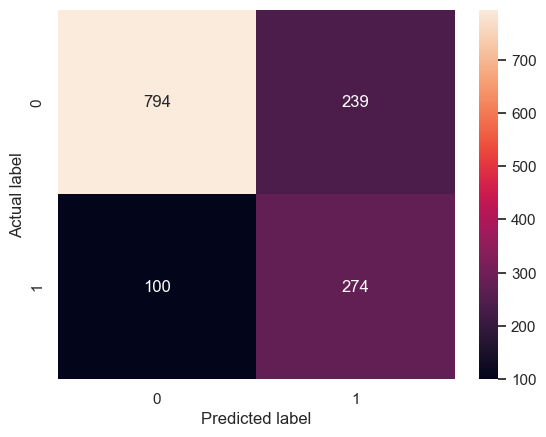

*******************************************
*********** Decision Tree *************
              precision    recall  f1-score   support

         0.0       0.88      0.76      0.82      1033
         1.0       0.52      0.71      0.60       374

    accuracy                           0.75      1407
   macro avg       0.70      0.73      0.71      1407
weighted avg       0.78      0.75      0.76      1407

*******************************************
Log loss score 0.46
*******************************************
Confusion matrix


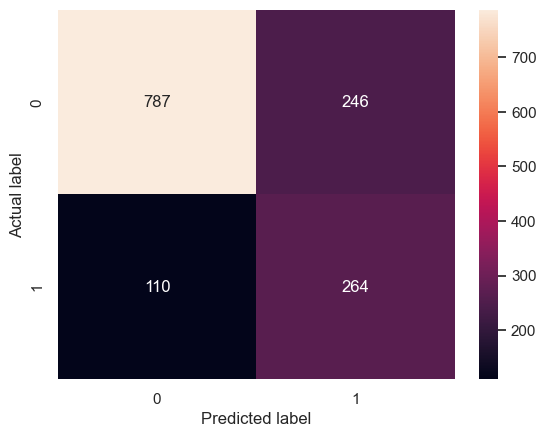

*******************************************
*********** Logistic Regression *************
              precision    recall  f1-score   support

         0.0       0.89      0.77      0.82      1033
         1.0       0.53      0.73      0.62       374

    accuracy                           0.76      1407
   macro avg       0.71      0.75      0.72      1407
weighted avg       0.79      0.76      0.77      1407

*******************************************
Log loss score 0.43
*******************************************
Confusion matrix


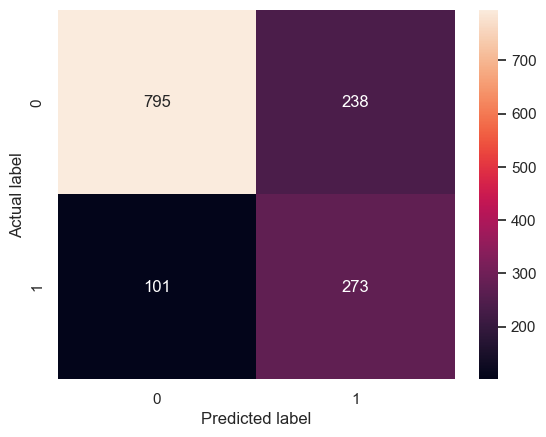

*******************************************
*********** XGBoost *************
              precision    recall  f1-score   support

         0.0       0.89      0.74      0.81      1033
         1.0       0.51      0.74      0.60       374

    accuracy                           0.74      1407
   macro avg       0.70      0.74      0.70      1407
weighted avg       0.78      0.74      0.75      1407

*******************************************
Log loss score 0.44
*******************************************
Confusion matrix


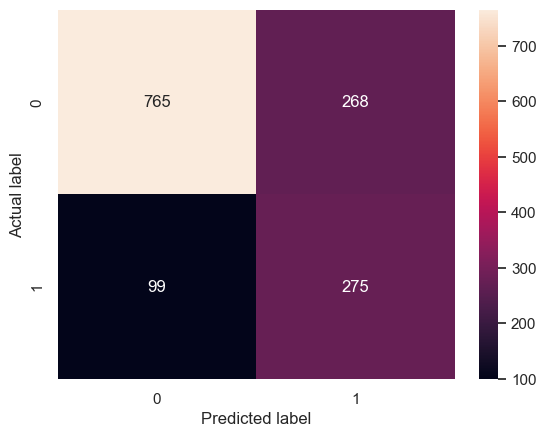

*******************************************


In [142]:
og_lr_threshold = 0.332674
og_dt_threshold = 0.315217
og_rf_threshold = 0.323857
og_xgb_threshold = 0.2982
Model_evaluation(og_clsModels
                 , clsModelsNm
                 , X_train
                 , y_train
                 , X_test
                 , y_test
                 , [og_rf_threshold
                    ,og_dt_threshold
                    , og_lr_threshold
                    , og_xgb_threshold] )


### Upsampling data

*********** Random Forest *************
              precision    recall  f1-score   support

         0.0       0.91      0.70      0.79      1033
         1.0       0.49      0.80      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.73      0.74      1407

*******************************************
Log loss score 0.48
*******************************************
Confusion matrix


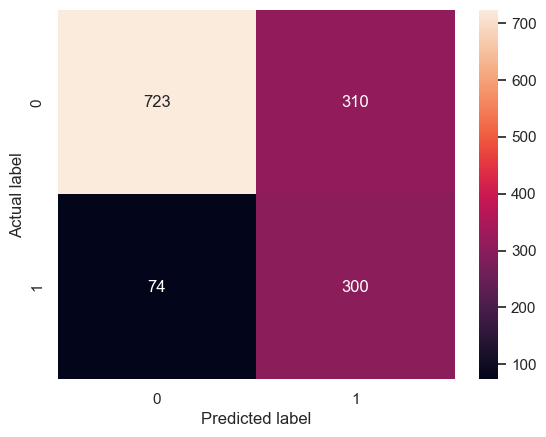

*******************************************
*********** Decision Tree *************
              precision    recall  f1-score   support

         0.0       0.92      0.65      0.76      1033
         1.0       0.46      0.84      0.59       374

    accuracy                           0.70      1407
   macro avg       0.69      0.74      0.68      1407
weighted avg       0.80      0.70      0.71      1407

*******************************************
Log loss score 0.61
*******************************************
Confusion matrix


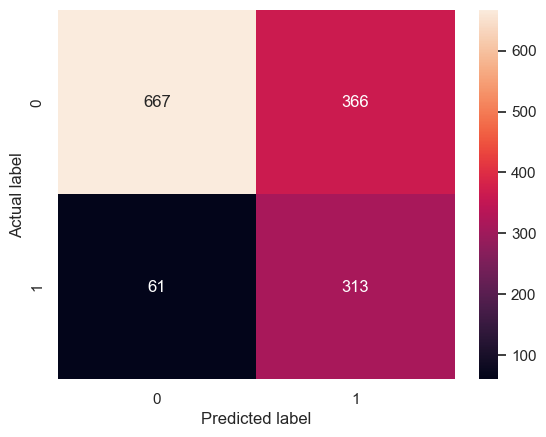

*******************************************
*********** Logistic Regression *************
              precision    recall  f1-score   support

         0.0       0.92      0.62      0.74      1033
         1.0       0.45      0.85      0.59       374

    accuracy                           0.68      1407
   macro avg       0.68      0.74      0.67      1407
weighted avg       0.80      0.68      0.70      1407

*******************************************
Log loss score 0.51
*******************************************
Confusion matrix


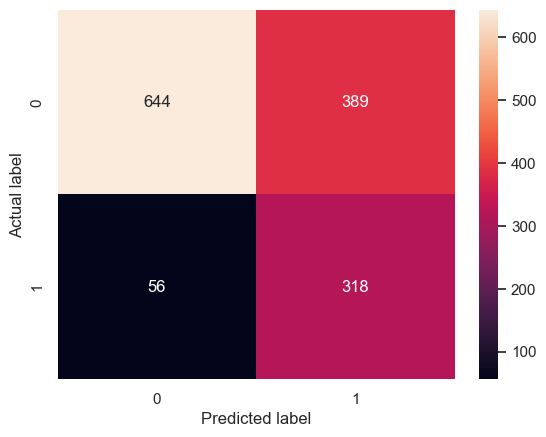

*******************************************
*********** XGBoost *************
              precision    recall  f1-score   support

         0.0       0.86      0.79      0.83      1033
         1.0       0.53      0.66      0.59       374

    accuracy                           0.75      1407
   macro avg       0.70      0.72      0.71      1407
weighted avg       0.78      0.75      0.76      1407

*******************************************
Log loss score 0.47
*******************************************
Confusion matrix


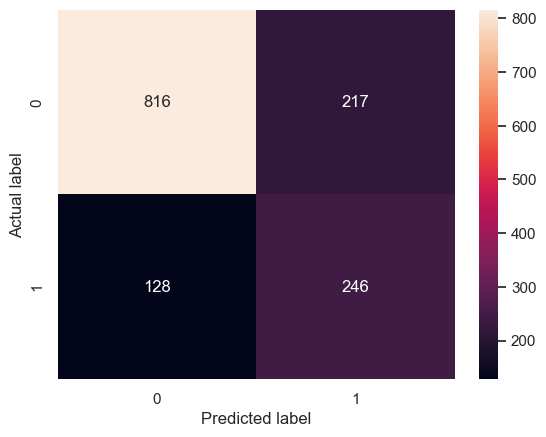

*******************************************


In [143]:
os_lr_threshold = 0.403967
os_dt_threshold = 0.395833
os_rf_threshold = 0.455383
os_xgb_threshold = 0.427983
Model_evaluation(os_clsModels
                 , clsModelsNm
                 , X_train_upsampled
                 , y_train_upsampled
                 , X_test
                 , y_test
                 , [os_rf_threshold
                    ,os_dt_threshold
                    , os_lr_threshold
                    , os_xgb_threshold] )


### Undersampling data

*********** Random Forest *************
              precision    recall  f1-score   support

         0.0       0.94      0.59      0.72      1033
         1.0       0.44      0.89      0.59       374

    accuracy                           0.67      1407
   macro avg       0.69      0.74      0.66      1407
weighted avg       0.80      0.67      0.69      1407

*******************************************
Log loss score 0.51
*******************************************
Confusion matrix


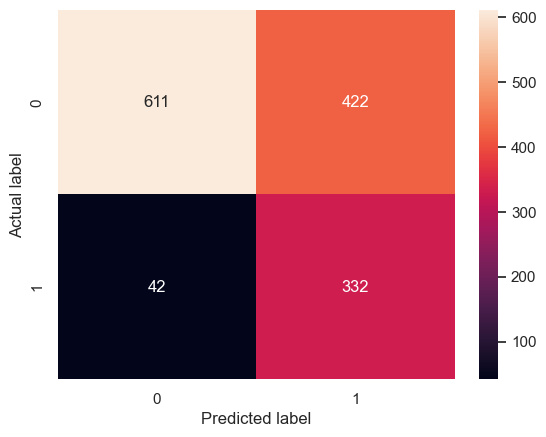

*******************************************
*********** Decision Tree *************
              precision    recall  f1-score   support

         0.0       0.95      0.49      0.65      1033
         1.0       0.40      0.92      0.55       374

    accuracy                           0.61      1407
   macro avg       0.67      0.71      0.60      1407
weighted avg       0.80      0.61      0.62      1407

*******************************************
Log loss score 0.59
*******************************************
Confusion matrix


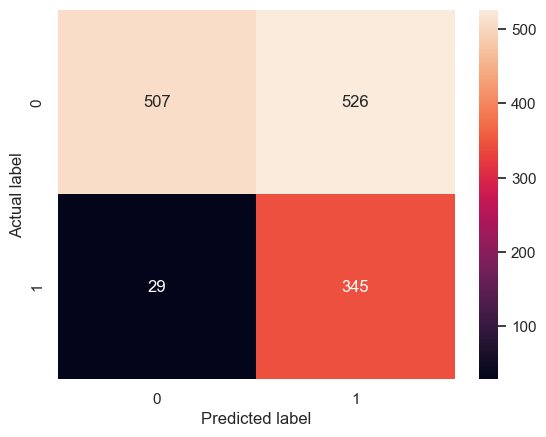

*******************************************
*********** Logistic Regression *************
              precision    recall  f1-score   support

         0.0       0.92      0.62      0.74      1033
         1.0       0.45      0.86      0.59       374

    accuracy                           0.68      1407
   macro avg       0.69      0.74      0.66      1407
weighted avg       0.80      0.68      0.70      1407

*******************************************
Log loss score 0.51
*******************************************
Confusion matrix


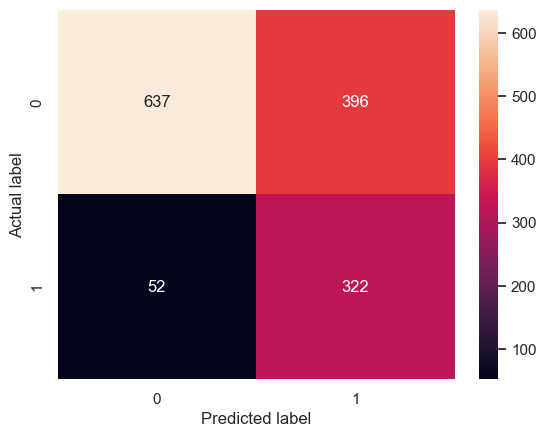

*******************************************
*********** XGBoost *************
              precision    recall  f1-score   support

         0.0       0.92      0.62      0.74      1033
         1.0       0.45      0.86      0.59       374

    accuracy                           0.68      1407
   macro avg       0.68      0.74      0.66      1407
weighted avg       0.80      0.68      0.70      1407

*******************************************
Log loss score 0.54
*******************************************
Confusion matrix


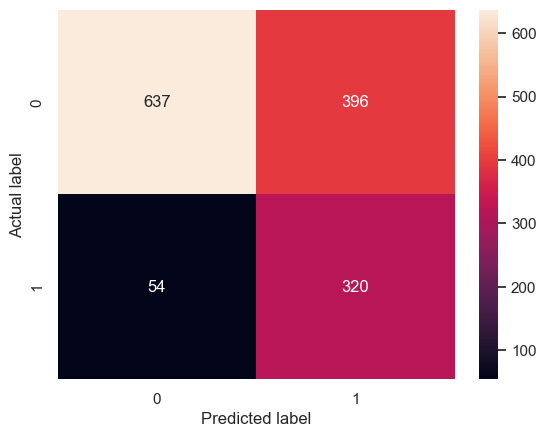

*******************************************


In [144]:
us_lr_threshold = 0.411026
us_dt_threshold = 0.307692
us_rf_threshold = 0.380141
us_xgb_threshold = 0.386117
Model_evaluation(us_clsModels
                 , clsModelsNm
                 , x_train_downsampled
                 , y_train_downsampled
                 , X_test
                 , y_test
                 , [us_rf_threshold
                    ,us_dt_threshold
                    , us_lr_threshold
                    , us_xgb_threshold] )


In [68]:
# ... existing code ...
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb

# Define features and target variable
X = data_scaled.drop(columns=['Churn'])  # Assuming 'Churn' is the target variable
y = data_scaled['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [300, 400],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probability estimates for AUC

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Output the results
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
# ... existing code ...

Fitting 3 folds for each of 36 candidates, totalling 108 fits


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [19:48:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Accuracy: 0.7832
AUC: 0.8136
F1 Score: 0.6034
Recall: 0.6203
Precision: 0.5873


In [69]:
# ... existing code ...
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

# Define features and target variable
X = data_scaled.drop(columns=['Churn'])  # Assuming 'Churn' is the target variable
y = data_scaled['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability estimates for AUC

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Output the results
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
# ... existing code ...

Accuracy: 0.7733
AUC: 0.8152
F1 Score: 0.5863
Recall: 0.6043
Precision: 0.5693


In [70]:
# ... existing code ...
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE
import lightgbm as lgb

# Define features and target variable
X = data_scaled.drop(columns=['Churn'])  # Assuming 'Churn' is the target variable
y = data_scaled['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the model
model = lgb.LGBMClassifier()

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [300, 400],
    'max_depth': [-1, 3, 5, 7],  # -1 means no limit
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 63, 127]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probability estimates for AUC

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Output the results
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
# ... existing code ...

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4130, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1864
[LightGBM] [Info] Number of data points in the train set: 8260, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,